<a href="https://colab.research.google.com/github/manish-gitx/ml_assignment/blob/main/manishassignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import essential Libraries

In [ ]:
import pandas as pd
import numpy as np

# Load Data


In [ ]:
url = 'https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/001/551/original/delhivery_data.csv?1642751181'
df = pd.read_csv(url)

# Basic Exploration


In [ ]:
print("Shape of Data:", df.shape)
print("Columns:", df.columns.tolist())
print("Missing Values:\n", df.isnull().sum())


Shape of Data: (144867, 24)
Columns: ['data', 'trip_creation_time', 'route_schedule_uuid', 'route_type', 'trip_uuid', 'source_center', 'source_name', 'destination_center', 'destination_name', 'od_start_time', 'od_end_time', 'start_scan_to_end_scan', 'is_cutoff', 'cutoff_factor', 'cutoff_timestamp', 'actual_distance_to_destination', 'actual_time', 'osrm_time', 'osrm_distance', 'factor', 'segment_actual_time', 'segment_osrm_time', 'segment_osrm_distance', 'segment_factor']
Missing Values:
 data                                0
trip_creation_time                  0
route_schedule_uuid                 0
route_type                          0
trip_uuid                           0
source_center                       0
source_name                       293
destination_center                  0
destination_name                  261
od_start_time                       0
od_end_time                         0
start_scan_to_end_scan              0
is_cutoff                           0
cutoff_factor

# Renaming columns for clarity


In [ ]:
df.rename(columns={
    'trip_uuid': 'Trip ID',
    'source_center': 'Source ID',
    'destination_center': 'Destination ID',
    'trip_creation_time': 'Trip Creation Time'
}, inplace=True)

# Add a unique identifier combining relevant fields


In [ ]:
df['Trip Details'] = df['Trip ID'] + '_' + df['Source ID'].astype(str) + '_' + df['Destination ID'].astype(str)

# Drop redundant columns


In [ ]:
df.drop(['Trip ID', 'Source ID', 'Destination ID'], axis=1, inplace=True)


# Convert timestamps to datetime


In [ ]:
df['od_start_time'] = pd.to_datetime(df['od_start_time'])
df['od_end_time'] = pd.to_datetime(df['od_end_time'])

# Feature Engineering: Calculate delivery time in seconds


In [ ]:
df['time_taken'] = (df['od_end_time'] - df['od_start_time']).dt.total_seconds()


# Drop original time columns if necessary


In [ ]:
df.drop(['od_start_time', 'od_end_time'], axis=1, inplace=True)


In [ ]:
df.fillna(df.median(numeric_only=True), inplace=True)


# Handle Missing Values: Replace NaN with median or appropriate values


In [ ]:
df_agg = df.groupby('Trip Details').agg({
    'actual_time': 'sum',
    'osrm_time': 'sum',
    'segment_actual_time': 'sum',
    'osrm_distance': 'sum',
    'segment_osrm_distance': 'sum',
    'time_taken': 'mean'
}).reset_index()

# Aggregation by 'Trip Details'


In [ ]:
from scipy.stats import ttest_ind

def perform_ttest(col1, col2, data):
    t_stat, p_val = ttest_ind(data[col1], data[col2])
    print(f"T-test between {col1} and {col2}: T-stat = {t_stat:.3f}, P-value = {p_val:.3f}")

perform_ttest('actual_time', 'osrm_time', df_agg)
perform_ttest('actual_time', 'segment_actual_time', df_agg)
perform_ttest('osrm_distance', 'segment_osrm_distance', df_agg)


T-test between actual_time and osrm_time: T-stat = 14.276, P-value = 0.000
T-test between actual_time and segment_actual_time: T-stat = 30.207, P-value = 0.000
T-test between osrm_distance and segment_osrm_distance: T-stat = 29.316, P-value = 0.000


# Hypothesis Testing: Compare aggregated fields


In [ ]:
from scipy.stats import ttest_ind

def perform_ttest(col1, col2, data):
    t_stat, p_val = ttest_ind(data[col1], data[col2])
    print(f"T-test between {col1} and {col2}: T-stat = {t_stat:.3f}, P-value = {p_val:.3f}")

perform_ttest('actual_time', 'osrm_time', df_agg)
perform_ttest('actual_time', 'segment_actual_time', df_agg)
perform_ttest('osrm_distance', 'segment_osrm_distance', df_agg)

# One-Hot Encoding for categorical variables


In [ ]:
if 'route_type' in df.columns:
    df = pd.concat([df, pd.get_dummies(df['route_type'], prefix='route')], axis=1)
    df.drop('route_type', axis=1, inplace=True)

# Normalize/Standardize Numerical Features


In [ ]:
for col in ['actual_time', 'osrm_time', 'segment_actual_time', 'osrm_distance', 'segment_osrm_distance']:
    if col in df_agg.columns:
        df_agg[col + '_scaled'] = (df_agg[col] - df_agg[col].min()) / (df_agg[col].max() - df_agg[col].min())

# Basic Insights


In [ ]:
print("\nBasic Insights:")
if 'destination_name' in df.columns:
    print("Top Destinations:", df['destination_name'].value_counts().head())

if 'source_name' in df.columns:
    print("Top Sources:", df['source_name'].value_counts().head())

print("Data Aggregation:\n", df_agg.head())


Basic Insights:
Top Destinations: destination_name
Gurgaon_Bilaspur_HB (Haryana)        15192
Bangalore_Nelmngla_H (Karnataka)     11019
Bhiwandi_Mankoli_HB (Maharashtra)     5492
Hyderabad_Shamshbd_H (Telangana)      5142
Kolkata_Dankuni_HB (West Bengal)      4892
Name: count, dtype: int64
Top Sources: source_name
Gurgaon_Bilaspur_HB (Haryana)        23347
Bangalore_Nelmngla_H (Karnataka)      9975
Bhiwandi_Mankoli_HB (Maharashtra)     9088
Pune_Tathawde_H (Maharashtra)         4061
Hyderabad_Shamshbd_H (Telangana)      3340
Name: count, dtype: int64
Data Aggregation:
                                         Trip Details  actual_time  osrm_time  \
0  trip-153671041653548748_IND209304AAA_IND000000ACB       6484.0     3464.0   
1  trip-153671041653548748_IND462022AAA_IND209304AAA       9198.0     4323.0   
2  trip-153671042288605164_IND561203AAB_IND562101AAA         96.0       55.0   
3  trip-153671042288605164_IND572101AAA_IND561203AAB        303.0      155.0   
4  trip-15367104336909

# Visualization


In [ ]:
import matplotlib.pyplot as plt

# Distribution of time_taken


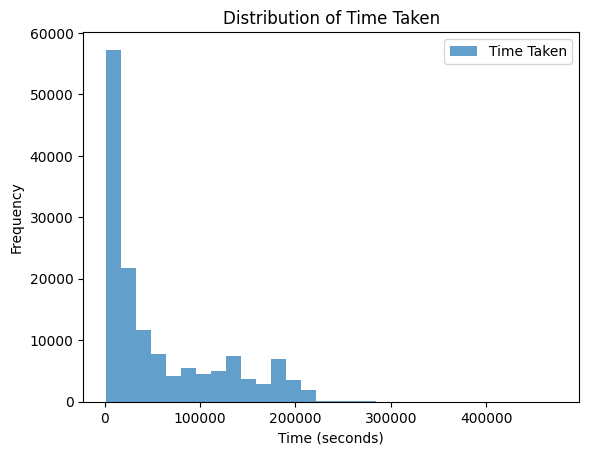

In [ ]:
plt.hist(df['time_taken'].dropna(), bins=30, alpha=0.7, label='Time Taken')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Time Taken')
plt.legend()
plt.show()

# Scatter plot for Actual Time vs OSRM Time


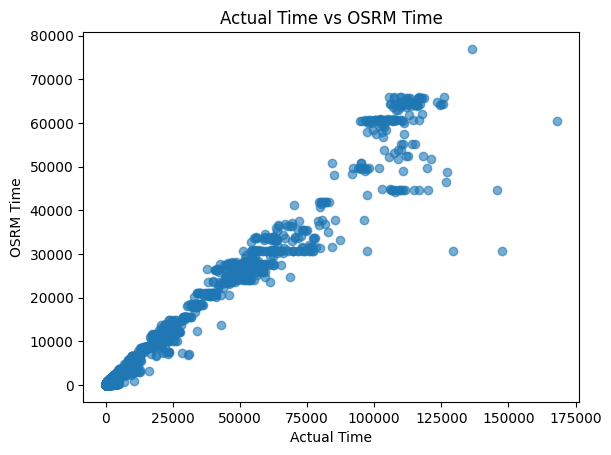

In [ ]:
plt.scatter(df_agg['actual_time'], df_agg['osrm_time'], alpha=0.6)
plt.xlabel('Actual Time')
plt.ylabel('OSRM Time')
plt.title('Actual Time vs OSRM Time')
plt.show()

# Outlier Treatment using IQR


In [ ]:
for col in ['actual_time', 'osrm_time', 'segment_actual_time']:
    if col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

print("\nData after Outlier Treatment:", df.head())


Data after Outlier Treatment:        data          Trip Creation Time  \
0  training  2018-09-20 02:35:36.476840   
1  training  2018-09-20 02:35:36.476840   
2  training  2018-09-20 02:35:36.476840   
3  training  2018-09-20 02:35:36.476840   
4  training  2018-09-20 02:35:36.476840   

                                 route_schedule_uuid  \
0  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...   
1  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...   
2  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...   
3  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...   
4  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...   

                  source_name               destination_name  \
0  Anand_VUNagar_DC (Gujarat)  Khambhat_MotvdDPP_D (Gujarat)   
1  Anand_VUNagar_DC (Gujarat)  Khambhat_MotvdDPP_D (Gujarat)   
2  Anand_VUNagar_DC (Gujarat)  Khambhat_MotvdDPP_D (Gujarat)   
3  Anand_VUNagar_DC (Gujarat)  Khambhat_MotvdDPP_D (Gujarat)   
4  Anand_VUNagar_DC (Gujarat)  Khambhat_MotvdDPP_D (G